Final Model Points = Final Model Test Score AUC - Modeling Violation Penalties

Permitted Model Types: 
Logistic Regression
K-Nearest Neibors Classification
Classification Trees
Random Forest 
Gradient Boosted Models

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier     
from sklearn.tree import plot_tree 
from sklearn.metrics import confusion_matrix        
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.metrics import make_scorer  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#loading data
file = './GOT_character_predictions.xlsx'

GOT = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# loading data dictionary
GOT_des = pd.read_excel(io = './GOT_data_dictionary.xlsx')

print(GOT.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [2]:
# checking for missing values

GOT.isnull().sum(axis=0)

#flagging the missing values
for col in GOT:
    if GOT[col].isnull().astype(int).sum() > 0:
        GOT['m_'+col] = GOT[col].isnull().astype(int)
        
GOT.isnull().sum(axis=0)


S.No                             0
name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
m_title                          0
m_culture                        0
m_dateOfBirth                    0
m_mother            

In [3]:
print(GOT['isAlive'].value_counts())

GOT_corr = GOT.corr(method = 'pearson')
GOT_corr['isAlive'].round(2).sort_values(ascending = True)


1    1451
0     495
Name: isAlive, dtype: int64


numDeadRelations             -0.19
popularity                   -0.18
book1_A_Game_Of_Thrones      -0.15
S.No                         -0.13
dateOfBirth                  -0.09
book2_A_Clash_Of_Kings       -0.07
isMarried                    -0.05
isAliveMother                -0.04
isNoble                      -0.04
book3_A_Storm_Of_Swords       0.01
book5_A_Dance_with_Dragons    0.03
m_house                       0.04
m_culture                     0.04
m_title                       0.04
m_spouse                      0.05
m_isAliveSpouse               0.05
age                           0.09
m_isAliveHeir                 0.13
m_heir                        0.13
m_isAliveMother               0.14
m_isAliveFather               0.14
m_mother                      0.14
m_father                      0.14
m_age                         0.15
m_dateOfBirth                 0.15
isAliveSpouse                 0.17
isAliveFather                 0.20
book4_A_Feast_For_Crows       0.27
isAliveHeir         

There are some features that already overlap with encoded features in the set. Therefor these features will be dropped. 

The spouse column is missing values, however the isMarried column is not. These two features are interchangable, so spouse will be dropped. This is also the case for features mother, father and heir, where the features isAliveHeir, isAliveFather, and isAliveMother will be used instead. 

Similarly the title feature is missing many values too, however the isNobel feature is not. Title would be relevant to determine a characters nobility and if this has an effect on him/her being alive or not. I will therefor continue only with the isNobel feature and drop title. 

Date of birth has an unidentified measure. This will not be helpful for any analysis, aside from having many missing values therefor this feature will be dropped. 

There are some other features:

isAliveMother
isAliveFather
isAliveHeir
isAliveSpouse

Where we will assume that NaN is 0 to be able to use these features in the analysis, taking into account the errors that could arise through the analysis if in case the true value would be 1 but was not recorded. 


In [4]:
#dropping unnecessary features
GOT = GOT.drop(['spouse', 'title', 'mother', 'father', 'heir', 'dateOfBirth'], axis = 1)

GOT.columns

Index(['S.No', 'name', 'culture', 'house', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir', 'm_isAliveSpouse', 'm_age'], dtype='object')

In [5]:
#imputing NaN values of isAliveMother, isAliveFather, isAliveHeir and isAliveSpouse with 0

GOT['isAliveMother'] = GOT['isAliveMother'].fillna(0)
GOT['isAliveFather'] = GOT['isAliveFather'].fillna(0)
GOT['isAliveHeir'] = GOT['isAliveHeir'].fillna(0)
GOT['isAliveSpouse'] = GOT['isAliveSpouse'].fillna(0)

GOT.isnull().sum(axis=0)

S.No                             0
name                             0
culture                       1269
house                          427
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                    0
isAliveFather                    0
isAliveHeir                      0
isAliveSpouse                    0
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
m_title                          0
m_culture                        0
m_dateOfBirth                    0
m_mother                         0
m_father                         0
m_heir                           0
m_house                          0
m_spouse                         0
m_isAliveMother                  0
m_isAliveFather     

After some research 'house' and 'culture' in Game of Thrones seem to be similar features. In the readings there is more emphasis on the house which characters belong to, this also represents the region they come from. Therefor I have decided to drop the feature 'culture' because there are more missing values here, and because of the stronger importance of 'house'.
The missing values of 'house' will be filled with a new category 'unknown' because any other imputation would be misleading in the representation of 'houses' for example if we were to fill it with the most often featured 'house', there would all of a sudden be 427 more characters allocated to that house which would have a large impact on our analysis. 

In [6]:
#imputing missing values for 'house'
GOT['house'] = GOT['house'].fillna(0)

GOT = GOT.drop(['culture'], axis = 1)

Now we will go into the descriptive statistics of the feature 'age' to determine how best to impute missing values. The values show that there are outliers in age in the form of negative numbers. I have decided to rule these outliers as an error and will change them to the mean. 

In [7]:
# checking age feature descriptive statistics
GOT['age'].describe()

# changing outliers to mean
GOT['age'].values[GOT['age'] < 0 ] = 0

# rechecking age feature 
GOT['age'].describe()


count    433.000000
mean      36.646651
std       25.876440
min        0.000000
25%       18.000000
50%       27.000000
75%       50.000000
max      100.000000
Name: age, dtype: float64

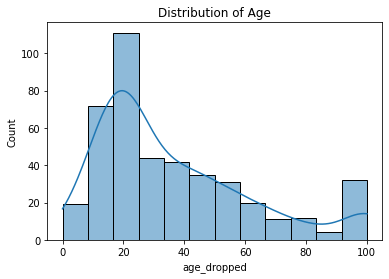

In [8]:
#making a dropped age column for visualisation
GOT['age_dropped'] = GOT['age'].dropna()

#visualising the feature age to determine best imputation strategy
#making a histogram to visualise distribution
sns.histplot(x='age_dropped',
            data = GOT,
            kde = True)

plt.title("Distribution of Age")
plt.show()

The histogram shows us a skewed age feature, therefor the missing values in age will be imputed with the median value.

In [9]:
age_median = GOT['age_dropped'].median()
GOT['age'] = GOT['age'].fillna(age_median).round(2)

In [10]:
GOT.info()
GOT.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   house                       1946 non-null   object 
 3   book1_A_Game_Of_Thrones     1946 non-null   int64  
 4   book2_A_Clash_Of_Kings      1946 non-null   int64  
 5   book3_A_Storm_Of_Swords     1946 non-null   int64  
 6   book4_A_Feast_For_Crows     1946 non-null   int64  
 7   book5_A_Dance_with_Dragons  1946 non-null   int64  
 8   isAliveMother               1946 non-null   float64
 9   isAliveFather               1946 non-null   float64
 10  isAliveHeir                 1946 non-null   float64
 11  isAliveSpouse               1946 non-null   float64
 12  isMarried                   1946 non-null   int64  
 13  isNoble                     1946 

S.No                          1946
name                          1946
house                          348
book1_A_Game_Of_Thrones          2
book2_A_Clash_Of_Kings           2
book3_A_Storm_Of_Swords          2
book4_A_Feast_For_Crows          2
book5_A_Dance_with_Dragons       2
isAliveMother                    2
isAliveFather                    2
isAliveHeir                      2
isAliveSpouse                    2
isMarried                        2
isNoble                          2
age                             83
numDeadRelations                14
popularity                     228
isAlive                          2
m_title                          2
m_culture                        2
m_dateOfBirth                    2
m_mother                         2
m_father                         2
m_heir                           2
m_house                          2
m_spouse                         2
m_isAliveMother                  2
m_isAliveFather                  2
m_isAliveHeir       

In [11]:
#exploring house feature further
GOT['house'].describe()

count     1946
unique     348
top          0
freq       427
Name: house, dtype: int64

In [12]:
#creating feature for characters with a house versus characters without one
GOT['is_house'] = 0

GOT.loc[GOT['house'] == 0, 'is_house'] = 0
GOT.loc[GOT['house'] != 0, 'is_house'] = 1
        
#checking new feature count
is_house_count = GOT['is_house'].value_counts()

print(is_house_count)

1    1519
0     427
Name: is_house, dtype: int64


In [13]:
#creating feature of characters only featured in the show (not books)

GOT['tv_only'] = 0

for index, value in GOT.iterrows():
    
    if GOT.loc[index, 'book1_A_Game_Of_Thrones'] == 0\
    and GOT.loc[index, 'book2_A_Clash_Of_Kings'] == 0\
    and GOT.loc[index, 'book3_A_Storm_Of_Swords'] == 0\
    and GOT.loc[index, 'book4_A_Feast_For_Crows'] == 0\
    and GOT.loc[index, 'book5_A_Dance_with_Dragons'] == 0:
        GOT.loc[index, 'tv_only'] = 1
        
#checking new feature count
tv_only_count = GOT['tv_only'].value_counts()
print(tv_only_count)

0    1674
1     272
Name: tv_only, dtype: int64


In [14]:
##feature engineering new feature 'gender'

##installing gender guesser
#%pip install gender_guesser

##splitting names 
#import gender_guesser.detector as gender

#placeholder_lst = []

#for index, col in GOT.iterrows():
    #split_name = GOT.loc[index, 'name'].split(sep=' ')
    #placeholder_lst.append(split_name)

##saving split names as new data frame
#name_df = pd.DataFrame(placeholder_lst)


#name_df

##adding name dataframe as new column in GOT

#name_df.columns = ['first_name','1','2','3','4','5']

#GOT = pd.concat([GOT, name_df['first_name']], axis = 1)

#GOT.head(n=5)

##guessing gender based on first name

#placeholder_lst = []

#for name in GOT['first_name']:
    #guess = gender.Detector().get_gender(name)
    #print(guess)
    #placeholder_lst.append(guess)
    
#GOT['gender_guess'] = pd.Series(placeholder_lst)

#GOT.head(n=5)

Tried to explore a new feature 'gender' by looping gender guesser through data set. The nature of the names
in the dataset however did not lead to results that are suitable to take this feature further. Only 10% of the names were recognized with a gender. The feature 'name' will therefor also be dropped for further analysis. 

In [15]:
#dropping unnecessary features 
GOT = GOT.drop(['age_dropped', 'name', 'house'], axis = 1)

#dropping missing value columns
GOT = GOT.drop(['m_house','m_culture', 'm_title', 'm_spouse', 'm_isAliveSpouse', 'm_heir',
               'm_isAliveHeir', 'm_mother', 'm_father', 'm_isAliveMother', 'm_isAliveFather',
               'm_dateOfBirth', 'm_age'], axis = 1)




In [16]:
#checking final features
GOT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   book1_A_Game_Of_Thrones     1946 non-null   int64  
 2   book2_A_Clash_Of_Kings      1946 non-null   int64  
 3   book3_A_Storm_Of_Swords     1946 non-null   int64  
 4   book4_A_Feast_For_Crows     1946 non-null   int64  
 5   book5_A_Dance_with_Dragons  1946 non-null   int64  
 6   isAliveMother               1946 non-null   float64
 7   isAliveFather               1946 non-null   float64
 8   isAliveHeir                 1946 non-null   float64
 9   isAliveSpouse               1946 non-null   float64
 10  isMarried                   1946 non-null   int64  
 11  isNoble                     1946 non-null   int64  
 12  age                         1946 non-null   float64
 13  numDeadRelations            1946 

In [17]:
GOT_corr = GOT.corr(method = 'pearson')
GOT_corr['isAlive'].round(2).sort_values(ascending = True)

numDeadRelations             -0.19
tv_only                      -0.18
popularity                   -0.18
age                          -0.18
book1_A_Game_Of_Thrones      -0.15
S.No                         -0.13
isAliveMother                -0.12
isAliveHeir                  -0.08
book2_A_Clash_Of_Kings       -0.07
isMarried                    -0.05
isAliveFather                -0.04
is_house                     -0.04
isNoble                      -0.04
isAliveSpouse                -0.01
book3_A_Storm_Of_Swords       0.01
book5_A_Dance_with_Dragons    0.03
book4_A_Feast_For_Crows       0.27
isAlive                       1.00
Name: isAlive, dtype: float64

Strongest correlations are seen for features:
numDeadRelations, tv_only, popularity and Age

In [18]:
#declaring explanatory variables and dropping y variable
GOT_explanatory = GOT.copy()
GOT_explanatory = GOT_explanatory.drop(['isAlive'], axis = 1)

for val in GOT_explanatory:
    print(f"{val} +")

S.No +
book1_A_Game_Of_Thrones +
book2_A_Clash_Of_Kings +
book3_A_Storm_Of_Swords +
book4_A_Feast_For_Crows +
book5_A_Dance_with_Dragons +
isAliveMother +
isAliveFather +
isAliveHeir +
isAliveSpouse +
isMarried +
isNoble +
age +
numDeadRelations +
popularity +
is_house +
tv_only +


In [19]:
#declaring response variable
GOT_target = GOT.loc[:, 'isAlive']

In [20]:
#preparing data for distance based algorithms
#standardizing GOT data 
scaler = StandardScaler()
scaler.fit(GOT_explanatory)
x_scaled = scaler.transform(GOT_explanatory)

GOT_scaled = pd.DataFrame(x_scaled)
GOT_scaled.describe().round(2)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00
mean,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.73,-0.50,-0.77,-0.96,-1.20,-0.81,-0.09,-0.05,-0.09,-0.35,-0.41,-0.92,-2.27,-0.22,-0.56,-1.89,-0.40
25%,-0.87,-0.50,-0.77,-0.96,-1.20,-0.81,-0.09,-0.05,-0.09,-0.35,-0.41,-0.92,-0.17,-0.22,-0.47,0.53,-0.40
50%,0.00,-0.50,-0.77,-0.96,0.83,-0.81,-0.09,-0.05,-0.09,-0.35,-0.41,-0.92,-0.17,-0.22,-0.35,0.53,-0.40
75%,0.87,-0.50,1.29,1.04,0.83,1.24,-0.09,-0.05,-0.09,-0.35,-0.41,1.08,-0.17,-0.22,-0.02,0.53,-0.40
max,1.73,2.01,1.29,1.04,0.83,1.24,11.35,19.70,11.35,2.84,2.46,1.08,5.52,10.62,5.67,0.53,2.48


In [21]:
#adding back columns
GOT_scaled.columns = GOT_explanatory.columns

#checking data set scaling
np.var(GOT_scaled)

S.No                          1.0
book1_A_Game_Of_Thrones       1.0
book2_A_Clash_Of_Kings        1.0
book3_A_Storm_Of_Swords       1.0
book4_A_Feast_For_Crows       1.0
book5_A_Dance_with_Dragons    1.0
isAliveMother                 1.0
isAliveFather                 1.0
isAliveHeir                   1.0
isAliveSpouse                 1.0
isMarried                     1.0
isNoble                       1.0
age                           1.0
numDeadRelations              1.0
popularity                    1.0
is_house                      1.0
tv_only                       1.0
dtype: float64

In [22]:
#train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(GOT_scaled,
                                                   GOT_target,
                                                   test_size = 0.10,
                                                   random_state = 219,
                                                   stratify = GOT_target)

GOT_train = pd.concat([x_train, y_train], axis = 1)

#checking sample size of testing and training sets
print(f"""
Response variable proportions training set : 
{y_train.value_counts(normalize = True).round(decimals=2)}

Response variable proportions testing set : 
{y_test.value_counts(normalize = True).round(decimals =2)}""")


Response variable proportions training set : 
1    0.75
0    0.25
Name: isAlive, dtype: float64

Response variable proportions testing set : 
1    0.74
0    0.26
Name: isAlive, dtype: float64


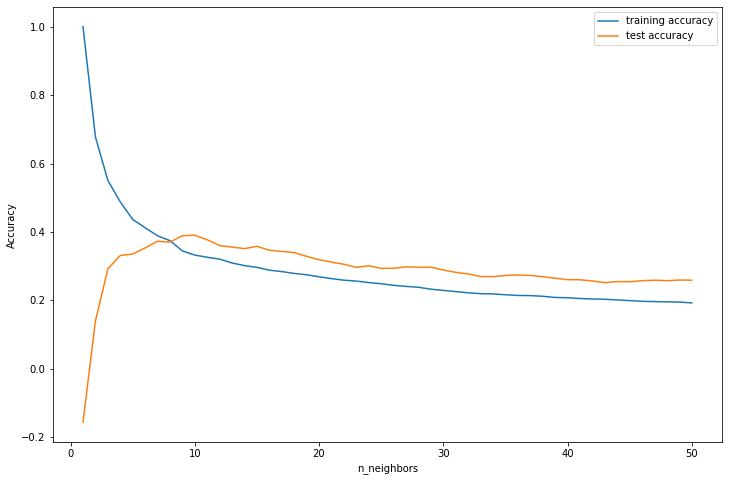

In [23]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 51)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [24]:
# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
print(f"""The optimal number of neighbors is {opt_neighbors}""")

The optimal number of neighbors is 10


In [25]:
knn = KNeighborsClassifier(n_neighbors = opt_neighbors)
knn_fit = knn.fit(x_train, y_train)
knn_pred = knn_fit.predict(x_test)

print('KNN Training Score:', knn.score(x_train, y_train).round(4))
print('KNN Testing Score:', knn.score(x_test, y_test).round(4))

knn_score_train = knn.score(x_train, y_train).round(4)
knn_score_test  = knn.score(x_test, y_test).round(4)


print('KNN Gap:', abs(knn_score_train - knn_score_test).round(4))
knn_test_gap = abs(knn_score_train - knn_score_test).round(4)
print('KNN AUC Score', roc_auc_score(y_true = y_test, y_score = knn_pred).round(4))
knn_auc_score = roc_auc_score(y_true = y_test, y_score = knn_pred).round(4)

KNN Training Score: 0.8155
KNN Testing Score: 0.8615
KNN Gap: 0.046
KNN AUC Score 0.7497


In [26]:
# unpacking the confusion matrix
knn_tn, \
knn_fp, \
knn_fn, \
knn_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tn}
False Positives: {knn_fp}
False Negatives: {knn_fn}
True Positives : {knn_tp}
""")


True Negatives : 26
False Positives: 24
False Negatives: 3
True Positives : 142



In [27]:
#print results of KNN

print(f"""
---------------------------------------
KNN Classification
---------------------------------------
True Negatives :     {knn_tn}
False Positives:     {knn_fp}
False Negatives:     {knn_fn}
True Positives :     {knn_tp}
AUC :                {knn_auc_score}
---------------------------------------

""")


---------------------------------------
KNN Classification
---------------------------------------
True Negatives :     26
False Positives:     24
False Negatives:     3
True Positives :     142
AUC :                0.7497
---------------------------------------




In [28]:
#logistic regression for full set of variables
logistic_full = smf.logit(formula = """ isAlive ~ 
numDeadRelations +
tv_only +
age +
popularity +
is_house +
book1_A_Game_Of_Thrones +
book2_A_Clash_Of_Kings +
book3_A_Storm_Of_Swords +
book4_A_Feast_For_Crows +
book5_A_Dance_with_Dragons +
isAliveMother +
isAliveFather +
isAliveHeir +
isAliveSpouse +
isMarried +
isNoble """,
            data = GOT)

results_full = logistic_full.fit()

print(results_full.summary2())

Optimization terminated successfully.
         Current function value: 0.481917
         Iterations 6
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.150     
Dependent Variable:    isAlive             AIC:                 1909.6201 
Date:                  2021-12-05 11:40    BIC:                 2004.3701 
No. Observations:      1946                Log-Likelihood:      -937.81   
Df Model:              16                  LL-Null:             -1103.5   
Df Residuals:          1929                LLR p-value:         7.4960e-61
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   

In [29]:
#logistic regression for full set of variables
logistic_sig = smf.logit(formula = """ isAlive ~ 
numDeadRelations +
tv_only +
age +
book1_A_Game_Of_Thrones +
book2_A_Clash_Of_Kings +
book3_A_Storm_Of_Swords +
book4_A_Feast_For_Crows +
popularity 
 """,
            data = GOT)

results_sig = logistic_sig.fit()

print(results_sig.summary2())

Optimization terminated successfully.
         Current function value: 0.485567
         Iterations 6
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.144     
Dependent Variable:   isAlive            AIC:                1907.8268 
Date:                 2021-12-05 11:40   BIC:                1957.9886 
No. Observations:     1946               Log-Likelihood:     -944.91   
Df Model:             8                  LL-Null:            -1103.5   
Df Residuals:         1937               LLR p-value:        8.6887e-64
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                1.7300   0.1675 10.3259 0.0000  1.4017

In [30]:
#creating dictionaries to store models

candidate_dict = {
    
    'logit_full' : ['numDeadRelations','tv_only','age', 'is_house','popularity','book1_A_Game_Of_Thrones',
                    'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords','book4_A_Feast_For_Crows','book5_A_Dance_with_Dragons',
                    'isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse','isMarried','isNoble'],
    
    'logit_sig' : ['numDeadRelations','tv_only','age','popularity','book1_A_Game_Of_Thrones',
                    'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords','book4_A_Feast_For_Crows']
}

In [31]:
#printing an overview of the variable sets

print(f"""

Explanatory Variable Sets
--------------------------

Full Model: 

{candidate_dict['logit_full']}

Significant P-Value Model:

{candidate_dict['logit_sig']}

""")



Explanatory Variable Sets
--------------------------

Full Model: 

['numDeadRelations', 'tv_only', 'age', 'is_house', 'popularity', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble']

Significant P-Value Model:

['numDeadRelations', 'tv_only', 'age', 'popularity', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows']




In [32]:
# train/test split with the full model
GOT_explanatory   =  GOT.loc[ : , candidate_dict['logit_full']]
GOT_target =  GOT.loc[ : , 'isAlive']


# creating testing and training data
x_train, x_test, y_train, y_test = train_test_split(
            GOT_explanatory,
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)



In [33]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219,
                           max_iter = 1000)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

Training ACCURACY: 0.7744
Testing  ACCURACY: 0.8256


In [34]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 20  30]
 [  4 141]]


In [35]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


In [36]:
#area under the curve (AUC)
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))

# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

0.6862


In [37]:
#print results of logreg

print(f"""
----------------------------------------------------------------------------------
Logistic Regression Full
----------------------------------------------------------------------------------
True Negatives :     {logreg_tn}
False Positives:     {logreg_fp}
False Negatives:     {logreg_fn}
True Positives :     {logreg_tp}
AUC :                {logreg_auc_score}
----------------------------------------------------------------------------------

""")


----------------------------------------------------------------------------------
Logistic Regression Full
----------------------------------------------------------------------------------
True Negatives :     20
False Positives:     30
False Negatives:     4
True Positives :     141
AUC :                0.6862
----------------------------------------------------------------------------------




Now to try the logistic regression with only the significant variables and observe the difference. 

In [38]:
# train/test split with the sig model
GOT_sig   =  GOT.loc[ : , candidate_dict['logit_sig']]
GOT_target =  GOT.loc[ : , 'isAlive']


# creating testing and training data
x_train_sig, x_test_sig, y_train_sig, y_test_sig = train_test_split(
            GOT_sig,
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)

In [39]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219,
                           max_iter = 1000)


# FITTING the training data
logreg_fit = logreg.fit(x_train_sig, y_train_sig)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test_sig)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train_sig, y_train_sig).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test_sig, y_test_sig).round(4))


# saving scoring data for future use
logreg_sig_train_score = logreg_fit.score(x_train_sig, y_train_sig).round(4) # accuracy
logreg_sig_test_score  = logreg_fit.score(x_test_sig, y_test_sig).round(4) # accuracy

Training ACCURACY: 0.7704
Testing  ACCURACY: 0.8256


In [40]:
# unpacking the confusion matrix
logreg_sig_tn, \
logreg_sig_fp, \
logreg_sig_fn, \
logreg_sig_tp = confusion_matrix(y_true = y_test_sig, y_pred = logreg_pred).ravel()

#area under the curve (AUC)
print(roc_auc_score(y_true  = y_test_sig,
                    y_score = logreg_pred).round(decimals = 4))

# saving AUC score for future use
logreg_auc_sig_score = roc_auc_score(y_true  = y_test_sig,
                                 y_score = logreg_pred).round(decimals = 4)

0.6862


In [41]:
#print results of logreg sig

print(f"""
----------------------------------------------------------------------------------
Logistic Regression Sig
----------------------------------------------------------------------------------
True Negatives :     {logreg_sig_tn}
False Positives:     {logreg_sig_fp}
False Negatives:     {logreg_sig_fn}
True Positives :     {logreg_sig_tp}
AUC :                {logreg_auc_sig_score}
----------------------------------------------------------------------------------

""")


----------------------------------------------------------------------------------
Logistic Regression Sig
----------------------------------------------------------------------------------
True Negatives :     20
False Positives:     30
False Negatives:     4
True Positives :     141
AUC :                0.6862
----------------------------------------------------------------------------------




With the results of the logit regression with default parameters, I will now try to get better results hyperparameter tuning with RandomizedSearchCV.

In [42]:
#declaring hyperparameter space
C_range          = np.arange(0.1, 5.0, 0.1)
warm_start_range = [True, False]
solver_range     = ['newton-cg', 'sag', 'lbfgs', 'saga']

# creating a hyperparameter grid
param_grid = {'C'          : C_range,
              'warm_start' : warm_start_range,
              'solver'     : solver_range}

# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000) 

# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(GOT_explanatory, GOT_target)

# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which

C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Tuned Parameters  : {'warm_start': False, 'solver': 'lbfgs', 'C': 4.7}
Tuned CV AUC      : 0.6038


C:\Users\Carmen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [43]:
lr_tuned_cv.best_estimator_

LogisticRegression(C=4.7, max_iter=1000, random_state=219)

In [44]:
#building a logit model with hyperparameter tuning best estimation
# INSTANTIATING a logistic regression model
tuned_logreg = LogisticRegression(solver = 'newton-cg',
                            C = 1.7000000000000002,
                            random_state = 219,
                           max_iter = 1000,
                           warm_start = True)


# FITTING the training data
tuned_logreg_fit = tuned_logreg.fit(GOT_explanatory, GOT_target)


# PREDICTING based on the testing set
tuned_logreg_pred = tuned_logreg_fit.predict(x_test)


# SCORING the results
tuned_logreg_fit.score(x_train, y_train).round(4)
tuned_logreg_fit.score(x_test, y_test).round(4)


# saving scoring data for future use
tuned_logreg_train_score = tuned_logreg_fit.score(x_train, y_train).round(4) # accuracy
tuned_logreg_test_score  = tuned_logreg_fit.score(x_test, y_test).round(4) # accuracy

#area under the curve (AUC)
roc_auc_score(y_true  = y_test,
                    y_score = tuned_logreg_pred).round(decimals = 4)

# saving AUC score for future use
tuned_logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = tuned_logreg_pred).round(decimals = 4)

# unpacking the confusion matrix
tuned_logreg_tn, \
tuned_logreg_fp, \
tuned_logreg_fn, \
tuned_logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


#print results of tuned logreg

print(f"""
----------------------------------------------------------------------------------
Tuned Logistic Regression
----------------------------------------------------------------------------------
Training Accuracy:   {tuned_logreg_train_score}
Testing Accuracy:    {tuned_logreg_test_score}
AUC :                {tuned_logreg_auc_score}

True Negatives :     {tuned_logreg_tn}
False Positives:     {tuned_logreg_fp}
False Negatives:     {tuned_logreg_fn}
True Positives :     {tuned_logreg_tp}
----------------------------------------------------------------------------------

""")


----------------------------------------------------------------------------------
Tuned Logistic Regression
----------------------------------------------------------------------------------
Training Accuracy:   0.7744
Testing Accuracy:    0.8256
AUC :                0.6862

True Negatives :     20
False Positives:     30
False Negatives:     4
True Positives :     141
----------------------------------------------------------------------------------




In [45]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran

In [46]:
#hyperparameter for classification tree model

#declaring hyperparameter space
criterion        = ['gini', 'entropy']
max_depth        = np.arange(4, 8, 1)
min_samples_leaf = np.arange(20, 200, 10)
max_features = ['auto', 'sqrt', 'log2']
splitter_range = ['best', 'random']

# creating a hyperparameter grid
param_grid = {'criterion'          : criterion,
              'max_depth' : max_depth,
              'min_samples_leaf'     : min_samples_leaf,
             'max_features' : max_features,
             'splitter' : splitter_range}

# INSTANTIATING the model object without hyperparameters
dt_tuned = DecisionTreeClassifier(random_state = 219) # increased for convergence

# GridSearchCV object
dt_tuned_cv = RandomizedSearchCV(estimator           = dt_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
dt_tuned_cv.fit(GOT_explanatory, GOT_target)

# printing the optimal parameters and best score
print("Tuned Parameters  :", dt_tuned_cv.best_params_)
print("Tuned CV AUC      :", dt_tuned_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy'}
Tuned CV AUC      : 0.6189


In [47]:
dt_tuned_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='log2',
                       min_samples_leaf=20, random_state=219)

In [48]:
#building a decision tree based on hyperparameter tuning values
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 7,
                                     min_samples_leaf = 30,
                                     max_features= 'sqrt',
                                     criterion = 'gini',
                                     splitter = 'best',
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(GOT_explanatory, GOT_target)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


#print results of tuned logreg

print(f"""
----------------------------------------------------------------------------------
Tuned Decision Tree
----------------------------------------------------------------------------------
Training Accuracy:   {pruned_tree_train_score}
Testing Accuracy:    {pruned_tree_test_score}
AUC :                {pruned_tree_test_score}

True Negatives :     {pruned_tree_tn}
False Positives:     {pruned_tree_fp}
False Negatives:     {pruned_tree_fn}
True Positives :     {pruned_tree_tp}
----------------------------------------------------------------------------------

""")

Training ACCURACY: 0.779
Testing  ACCURACY: 0.8308
AUC Score        : 0.6831

----------------------------------------------------------------------------------
Tuned Decision Tree
----------------------------------------------------------------------------------
Training Accuracy:   0.779
Testing Accuracy:    0.8308
AUC :                0.8308

True Negatives :     19
False Positives:     31
False Negatives:     2
True Positives :     143
----------------------------------------------------------------------------------




In [49]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

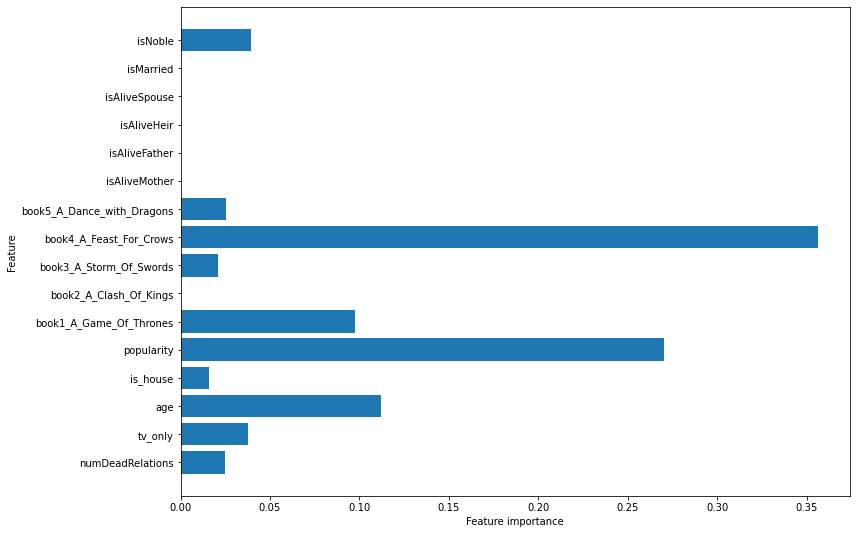

In [50]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = x_train,
                         export = False)

In [51]:
#random forest model

#instantiating object
forest = RandomForestClassifier(n_estimators = 100,
                               max_depth = 8)

#fit training data
forest_fit = forest.fit(x_train, y_train)

#predict on new data
forest_pred = forest.predict(x_test)

# SCORING the model
print('Training ACCURACY:', forest_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', forest_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = forest_pred).round(4))


# saving scoring data for future use
forest_train_score = forest_fit.score(x_train, y_train).round(4) # accuracy
forest_test_score  = forest_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
forest_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = forest_pred).round(4) # auc

# unpacking the confusion matrix
forest_tn, \
forest_fp, \
forest_fn, \
forest_tp = confusion_matrix(y_true = y_test, y_pred = forest_pred).ravel()


#print results of tuned logreg

print(f"""
----------------------------------------------------------------------------------
Random Forest Classification
----------------------------------------------------------------------------------
Training Accuracy:   {forest_train_score}
Testing Accuracy:    {forest_test_score}
AUC :                {forest_auc_score}

True Negatives :     {forest_tn}
False Positives:     {forest_fp}
False Negatives:     {forest_fn}
True Positives :     {forest_tp}
----------------------------------------------------------------------------------

""")

Training ACCURACY: 0.8538
Testing  ACCURACY: 0.8821
AUC Score        : 0.7831

----------------------------------------------------------------------------------
Random Forest Classification
----------------------------------------------------------------------------------
Training Accuracy:   0.8538
Testing Accuracy:    0.8821
AUC :                0.7831

True Negatives :     29
False Positives:     21
False Negatives:     2
True Positives :     143
----------------------------------------------------------------------------------




In [52]:
#creating a dictionary for model results
model_performance = {
    'Model Name' : ['KNN', 'Logistic (Full)', 'Logistic (Sig)', 'Logistic (Tuned)', 'Decision Tree (Tuned)'],
    
    'AUC Score' : [knn_auc_score, logreg_auc_score, logreg_auc_sig_score, tuned_logreg_auc_score, pruned_tree_auc_score],
    
    'Training Score' : [knn_score_train, logreg_train_score, logreg_sig_train_score, tuned_logreg_train_score, pruned_tree_train_score],
    
    'Testing Score' : [knn_score_test, logreg_test_score, logreg_sig_test_score, tuned_logreg_test_score, pruned_tree_test_score],
    
    'Confusion Matrix' : [(knn_tn, knn_fp, knn_fn, knn_tp),
                         (logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                          (logreg_sig_tn, logreg_sig_fp, logreg_sig_fn, logreg_sig_tp),
                         (tuned_logreg_tn, tuned_logreg_fp, tuned_logreg_fn, tuned_logreg_tp),
                          (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]

}


#converting model_performance into DF
model_performance = pd.DataFrame(model_performance)

# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Default)',
                           'AUC Score'          : forest_auc_score,
                           'Training Score'  : forest_train_score,
                           'Testing Score'   : forest_test_score,
                           'Confusion Matrix'   : (forest_tn,
                                                   forest_fp,
                                                   forest_fn,
                                                   forest_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Score,Testing Score,Confusion Matrix
0,KNN,0.7497,0.8155,0.8615,"(26, 24, 3, 142)"
1,Logistic (Full),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
2,Logistic (Sig),0.6862,0.7704,0.8256,"(20, 30, 4, 141)"
3,Logistic (Tuned),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
4,Decision Tree (Tuned),0.6831,0.7790,0.8308,"(19, 31, 2, 143)"
5,Random Forest (Default),0.7831,0.8538,0.8821,"(29, 21, 2, 143)"


In [53]:
# #hyperparameter tuning for random forest

# #declaring hyperparameter space
# estimator_range  = [100, 300, 500, 800]
# max_features = ['auto', 'sqrt', 'log2']
# max_depth = [5, 8]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]

# # creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_range,
#                'max_features' : max_features,
#               'max_depth' : max_depth,
#               'min_samples_split' : min_samples_split,
#               'min_samples_leaf' : min_samples_leaf
#              }

# # INSTANTIATING the model object without hyperparameters
# dt_tuned = RandomForestClassifier(random_state = 219) # increased for convergence

# # GridSearchCV object
# dt_tuned_cv = RandomizedSearchCV(estimator           = dt_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)


# # FITTING to the FULL DATASET (due to cross-validation)
# dt_tuned_cv.fit(GOT_sig, GOT_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", dt_tuned_cv.best_params_)
# print("Tuned CV AUC      :", dt_tuned_cv.best_score_.round(4))


In [54]:
#random forest model tuned

#instantiating object
forest_tuned = RandomForestClassifier(n_estimators = 500,
                               max_depth = 8,
                               max_features = 'log2',
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               random_state = 219)

#fit training data
forest_tuned_fit = forest_tuned.fit(x_train, y_train)

#predict on new data
forest_tuned_pred = forest_tuned.predict(x_test)

# SCORING the model
print('Training ACCURACY:', forest_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', forest_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned_fit.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
forest_tuned_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = forest_tuned_pred).round(4) # auc

# unpacking the confusion matrix
forest_tuned_tn, \
forest_tuned_fp, \
forest_tuned_fn, \
forest_tuned_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


#print results of tuned logreg

print(f"""
----------------------------------------------------------------------------------
Tuned Random Forest Classification
----------------------------------------------------------------------------------
Training Accuracy:   {forest_tuned_train_score}
Testing Accuracy:    {forest_tuned_test_score}
AUC :                {forest_tuned_auc_score}

True Negatives :     {forest_tuned_tn}
False Positives:     {forest_tuned_fp}
False Negatives:     {forest_tuned_fn}
True Positives :     {forest_tuned_tp}
----------------------------------------------------------------------------------

""")

Training ACCURACY: 0.8561
Testing  ACCURACY: 0.8821
AUC Score        : 0.7897

----------------------------------------------------------------------------------
Tuned Random Forest Classification
----------------------------------------------------------------------------------
Training Accuracy:   0.8561
Testing Accuracy:    0.8821
AUC :                0.7897

True Negatives :     30
False Positives:     20
False Negatives:     3
True Positives :     142
----------------------------------------------------------------------------------




In [55]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Tuned)',
                           'AUC Score'          : forest_tuned_auc_score,
                           'Training Score'  : forest_tuned_train_score,
                           'Testing Score'   : forest_tuned_test_score,
                           'Confusion Matrix'   : (forest_tuned_tn,
                                                   forest_tuned_fp,
                                                   forest_tuned_fn,
                                                   forest_tuned_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Score,Testing Score,Confusion Matrix
0,KNN,0.7497,0.8155,0.8615,"(26, 24, 3, 142)"
1,Logistic (Full),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
2,Logistic (Sig),0.6862,0.7704,0.8256,"(20, 30, 4, 141)"
3,Logistic (Tuned),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
4,Decision Tree (Tuned),0.6831,0.7790,0.8308,"(19, 31, 2, 143)"
5,Random Forest (Default),0.7831,0.8538,0.8821,"(29, 21, 2, 143)"
6,Random Forest (Tuned),0.7897,0.8561,0.8821,"(30, 20, 3, 142)"


In [56]:
#gradient boosting classifiert with default parameters

default_gbm = GradientBoostingClassifier(loss = 'deviance',
                                        learning_rate = 0.1,
                                        n_estimators = 100,
                                        subsample = 1.0,
                                        criterion = 'friedman_mse',
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        min_weight_fraction_leaf = 0.0,
                                        max_depth = 3,
                                        min_impurity_decrease = 0.0,
                                        init = None,
                                        random_state = 219,
                                        max_features = None,
                                        verbose = 0,
                                        max_leaf_nodes = None,
                                        warm_start = False,
                                        validation_fraction = 0.1,
                                        n_iter_no_change = None)

default_gbm_fit = default_gbm.fit(x_train, y_train)

default_gbm_pred = default_gbm.predict(x_test)

gbm_default_train_score =  default_gbm_fit.score(x_train, y_train).round(4)
gbm_default_test_score = default_gbm_fit.score(x_test, y_test).round(4)
gbm_default_auc_score = roc_auc_score(y_true  = y_test,
                                          y_score = default_gbm_pred).round(4)

# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = forest_pred).ravel()

In [57]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Gradient Boosting (default)',
                           'AUC Score'          : gbm_default_auc_score,
                           'Training Score'  : gbm_default_train_score,
                           'Testing Score'   : gbm_default_test_score,
                           'Confusion Matrix'   : (gbm_default_tn,
                                                   gbm_default_fp,
                                                   gbm_default_fn,
                                                   gbm_default_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Score,Testing Score,Confusion Matrix
0,KNN,0.7497,0.8155,0.8615,"(26, 24, 3, 142)"
1,Logistic (Full),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
2,Logistic (Sig),0.6862,0.7704,0.8256,"(20, 30, 4, 141)"
3,Logistic (Tuned),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
4,Decision Tree (Tuned),0.6831,0.7790,0.8308,"(19, 31, 2, 143)"
5,Random Forest (Default),0.7831,0.8538,0.8821,"(29, 21, 2, 143)"
6,Random Forest (Tuned),0.7897,0.8561,0.8821,"(30, 20, 3, 142)"
7,Gradient Boosting (default),0.7590,0.8447,0.8462,"(29, 21, 2, 143)"


Hyperparameter tuning for gradient boosting is time consuming. Therefor I will try and find the sweet spot for 
certain parameters by mapping them out instead and see what my results are. 

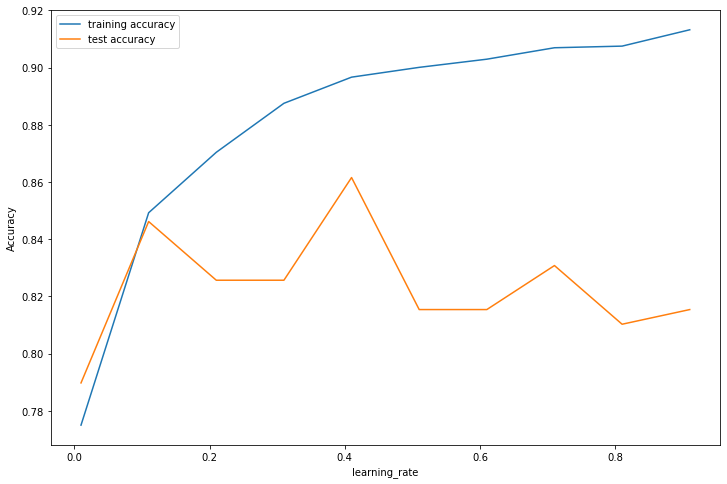

In [58]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 0.01 to 1 learning rate
learning_rate_settings = np.arange(0.01, 1, 0.1)


for learning_rate in learning_rate_settings:
    # Building the model
    clf = GradientBoostingClassifier(learning_rate = learning_rate)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(learning_rate_settings, training_accuracy, label = "training accuracy")
plt.plot(learning_rate_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("learning_rate")
plt.legend()
plt.show()

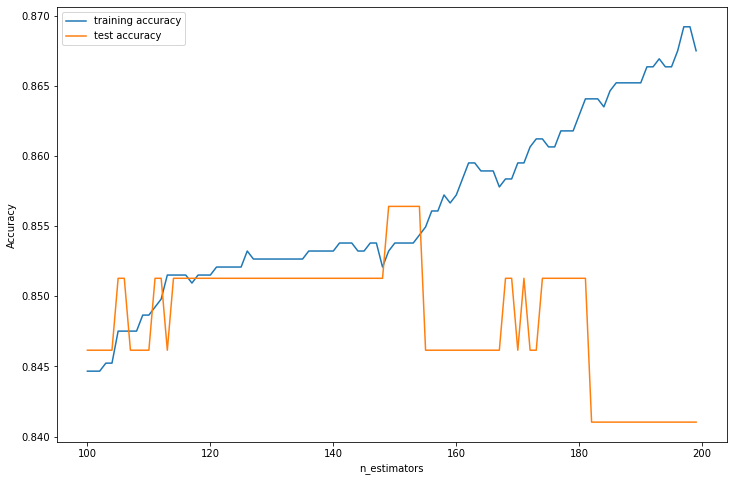

In [59]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 100 to 200 n_estimators
n_estimators_settings = range(100, 200)


for n_estimators in n_estimators_settings:
    # Building the model
    clf = GradientBoostingClassifier(n_estimators = n_estimators)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(n_estimators_settings, training_accuracy, label = "training accuracy")
plt.plot(n_estimators_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

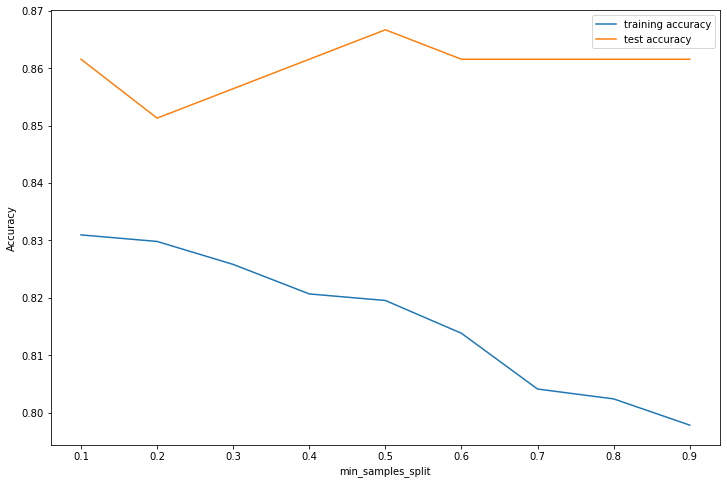

In [60]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 
min_samples_split_settings = np.arange(0.1, 1.0, 0.1)


for min_samples_split in min_samples_split_settings:
    # Building the model
    clf = GradientBoostingClassifier(min_samples_split = min_samples_split)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(min_samples_split_settings, training_accuracy, label = "training accuracy")
plt.plot(min_samples_split_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("min_samples_split")
plt.legend()
plt.show()

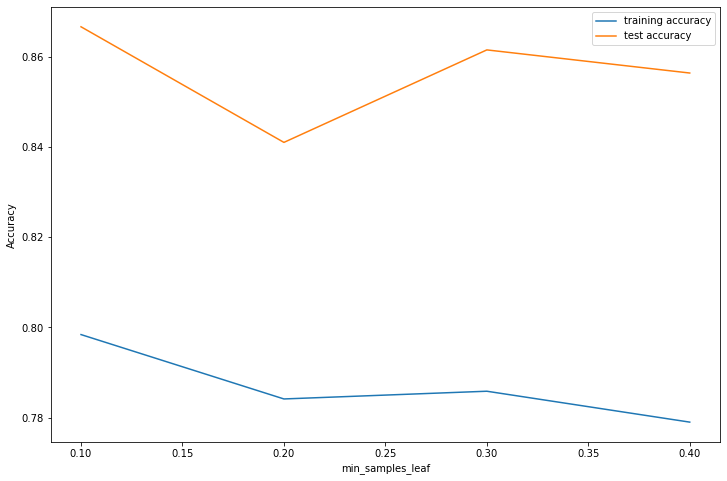

In [61]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 
min_samples_leaf_settings = np.arange(0.1, 0.5, 0.1)


for min_samples_leaf in min_samples_leaf_settings:
    # Building the model
    clf = GradientBoostingClassifier(min_samples_leaf = min_samples_leaf)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(min_samples_leaf_settings, training_accuracy, label = "training accuracy")
plt.plot(min_samples_leaf_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("min_samples_leaf")
plt.legend()
plt.show()

In [62]:
#building a model based on optimal features for gradient boosting

# INSTANTIATING the model object without hyperparameters
full_gbm_tuned = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 150,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                            min_samples_split = 0.5,
                                            min_samples_leaf = 0.1,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_tuned_fit = full_gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_tuned_pred = full_gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_tuned_pred).round(4))


gbm_tuned_train_score = full_gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_tuned_test_score = full_gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_tuned_auc_score = roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_tuned_pred).round(4)
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

Training ACCURACY: 0.8047
Testing ACCURACY : 0.8718
AUC Score        : 0.7893

True Negatives : 31
False Positives: 19
False Negatives: 6
True Positives : 139



In [63]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Gradient Boosting (Tuned)',
                           'AUC Score'          : gbm_tuned_auc_score,
                           'Training Score'  : gbm_tuned_train_score,
                           'Testing Score'   : gbm_tuned_test_score,
                           'Confusion Matrix'   : (gbm_tuned_tn,
                                                   gbm_tuned_fp,
                                                   gbm_tuned_fn,
                                                   gbm_tuned_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Score,Testing Score,Confusion Matrix
0,KNN,0.7497,0.8155,0.8615,"(26, 24, 3, 142)"
1,Logistic (Full),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
2,Logistic (Sig),0.6862,0.7704,0.8256,"(20, 30, 4, 141)"
3,Logistic (Tuned),0.6862,0.7744,0.8256,"(20, 30, 4, 141)"
4,Decision Tree (Tuned),0.6831,0.7790,0.8308,"(19, 31, 2, 143)"
5,Random Forest (Default),0.7831,0.8538,0.8821,"(29, 21, 2, 143)"
6,Random Forest (Tuned),0.7897,0.8561,0.8821,"(30, 20, 3, 142)"
7,Gradient Boosting (default),0.7590,0.8447,0.8462,"(29, 21, 2, 143)"
8,Gradient Boosting (Tuned),0.7893,0.8047,0.8718,"(31, 19, 6, 139)"


Gradient Boosting with default settings has the smallest training and testing gap from all models run so far. When tuning is performed it comes at the expense of the train test gap. Random Forest tuned has the highes AUC score from the models tested with a train test gap below 0.05.

In [64]:
# printing results
print(f"""
Model         AUC Score      Training Score, Testing Score            TN, FP, FN, TP
-----         ---------      -----------------------------            ---------------------------------------
KNN           {knn_auc_score}        {knn_score_train, knn_score_test}                           {knn_tn, knn_fp, knn_fn, knn_tp}
Logit Full    {logreg_auc_score}        {logreg_train_score, logreg_test_score}                           {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Logit Sig     {logreg_auc_sig_score}        {logreg_sig_train_score, logreg_sig_test_score}                           {logreg_sig_tn, logreg_sig_fp, logreg_sig_fn, logreg_sig_tp}
Logit Tuned   {tuned_logreg_auc_score}        {tuned_logreg_train_score, logreg_test_score}                           {tuned_logreg_tn, logreg_fp, logreg_fn, logreg_tp}
DT Tuned      {pruned_tree_auc_score}        {pruned_tree_train_score, pruned_tree_test_score}                            {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
RF Default    {forest_auc_score}        {forest_train_score, forest_test_score}                           {forest_tn, forest_fp, forest_fn, forest_tp}
*RF Tuned     {forest_tuned_auc_score}        {forest_tuned_train_score, forest_tuned_test_score}                           {forest_tuned_tn, forest_tuned_fp, forest_tuned_fn, forest_tuned_tp}
GB Default    {gbm_default_auc_score}         {gbm_default_train_score, gbm_default_test_score}                           {gbm_default_tn, gbm_default_fp, gbm_default_fn, gbm_default_tp}
GB Tuned      {gbm_tuned_auc_score}        {gbm_tuned_train_score, gbm_tuned_test_score}                           {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}

* final model
""")



Model         AUC Score      Training Score, Testing Score            TN, FP, FN, TP
-----         ---------      -----------------------------            ---------------------------------------
KNN           0.7497        (0.8155, 0.8615)                           (26, 24, 3, 142)
Logit Full    0.6862        (0.7744, 0.8256)                           (20, 30, 4, 141)
Logit Sig     0.6862        (0.7704, 0.8256)                           (20, 30, 4, 141)
Logit Tuned   0.6862        (0.7744, 0.8256)                           (20, 30, 4, 141)
DT Tuned      0.6831        (0.779, 0.8308)                            (19, 31, 2, 143)
*RF Default   0.7831        (0.8538, 0.8821)                           (29, 21, 2, 143)
RF Tuned      0.7897        (0.8561, 0.8821)                           (30, 20, 3, 142)
GB Default    0.759         (0.8447, 0.8462)                           (29, 21, 2, 143)
GB Tuned      0.7893        (0.8047, 0.8718)                           (31, 19, 6, 139)

* final mod